In [1]:
"""
import necessary modules
"""
from scipy.interpolate import griddata
import numpy as np
from dorna2 import Dorna
from camera import Camera
from dorna_vision import Detection
import time
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from tool import util

"""
parameters
"""
robot_ip_address = "169.254.76.134" # robot ip address
output_config = {
    "pick": [0, 1, 0],
}

tcp = {
    "vial": [0, 0, 52, 0, 0, 0], #3
}

imaging_joint = [0, 51.086426, -143.239746, 0, 2.131348, 0]
middle_joint = imaging_joint

speed_pick = 0.7 # here set the speed of the robot
above = [10, 70, 70, 70]
motion = "lmove"
sim=0
freedom = {"num" : 10, "range" : [0.01,0.01,0.01], "early_exit": False }

# detection parameters
detection_parameters = {
    "camera_mount":{
        "type": "dorna_ta_j4",
        "ej": [0 ,0,0, 0, 0, 0, 0, 0],
        "T": [46.5174596+1+1+1.5, 32.0776662-3+1-0-2-0.75, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
        #"T": [46.5174596, 32.0776662, -4.24772615, -0.27547989, 0.27691881, 89.6939516]
    },
    'detection': {'cmd': 'od', 'path': 'vial.pkl', 'conf': 0.9, 'cls': []}, 
    #'limit': {'area': [0, 100000], 'aspect_ratio': [0.1, 1.0], 'xyz': [[190, 360], [-125, 125], [40, 47]], 'inv': 0},
    'output': {'max_det': 100, 'shuffle': True, 'save_img': True, 'save_img_roi': True}
}

# good candidate
xyz_min = 40
aspect_ratio = 0.9

# grasp
rvec_base = [180, 0, 0]
padding = 5 # pixel 10
gripper_opening = 8 # mm 12
gripper_thickness = 8 # pxl
pick_samples = 64

place_pose = [317.098755, -193.586093, 124.534308, 169.668382, -54.160709, -1.459558]

rvec_error_thr = 5 # mm
xyz_error_thr = 5 # mm

In [2]:
w = 85
h = 125
microplate_points = [
    [0, 0, 0],   # Corner 1
    [w, 0, 0],   # Corner 2
    [w, h, 0],   # Corner 3
    [0, h, 0]    # Corner 4
]

pxl_ref = np.array([
    [279, 153],
    [192, 31],
    [723, 20],
    [732, 365],
    [197, 366],
    [254, 300],
    [263, 80],
    [304, 15],
    [430, 13],
    [430, 157],
    [594, 98],
    [583, 271],
    [464, 193],
    [606, 127],
    [708, 176],
    [449, 343],
    [332, 292],
    [601, 212],
    [403, 160],
    [442, 115],
    [352, 112],
    [348, 217],
    [412, 196],
    [453, 174],
    [616, 33],
    [578, 93],
    [691, 261],
    [676, 287],
    [634, 310],
    [590, 334],
    [188, 108],
    [230, 168],
    [183, 208],
    [222, 251],
    [280, 345],
    [320, 301],
    [360, 345],
    [381, 301],
    [418, 344],
])

xyz_ref = np.array([
    [290.90210028358894, 79.45882691588076, 45],
    [344.3598891767988, 117.90035871461907, 45],
    [350.1904187172848, -107.34523327411128, 45],
    [204.5069516941986, -110.55135398809965, 45],
    [201.25132034527442, 113.72582618881837, 45],
    [229.34564696427302, 89.138949864513, 45],
    [321.4944295389124, 87.50779637948679, 45],
    [350.70599135407906, 70.52116341656065, 45],
    [352.1628206379004, 16.225930787294054, 45],
    [289.49163727908984, 15.881618889965054, 45],
    [315.89784808122585, -52.112936482571385, 45],
    [243.0792456488096, -48.067271358361765, 45],
    [275.253159385206, 1.9444194138581636, 45],
    [303.9334330670534, -57.20419835735126, 45],
    [283.418498756174, -101.17327825408782, 45],
    [212.14158298651475, 7.917937061938289, 45],
    [233.41665886091624, 56.58740348932104, 45],
    [267.66999862744495, -55.39548447714354, 45],
    [288.5434535502941, 27.22536020498923, 45],
    [307.39553588898605, 10.908325990075102, 45],
    [308.45821502909627, 48.45709046150807, 45],
    [264.42425169755865, 50.000731068608815, 45],
    [273.4099052754199, 23.34352880207776, 45],
    [282.7672900921605, 6.203106097041072, 45],
    [344.4230915484399, -61.604720867953375, 45],
    [318.0863959210724, -44.54286990130542, 45],
    [247.90737025774132, -93.66525676728132, 45],
    [236.82952149094683, -87.59160398327872, 45],
    [226.98034004909206, -69.29674320580575, 45],
    [216.86936891522095, -50.78467372871498, 45],
    [309.87948657273967, 117.85438975669476, 45],
    [284.49063233721023, 100.54439513778848, 45],
    [267.48780428458326, 119.1745674308285, 45],
    [249.89321112906842, 102.80142638971905, 45], 
    [210.56755598965992, 78.39030678290776, 45],
    [229.54462100475206, 61.29680149363408, 45],
    [211.17109708713718, 44.82852133591946, 45],
    [229.74157755372133, 36.08106530565775, 45],
    [210.9808555180205, 20.505176027961557, 45],   
])


In [ ]:
"""
initialize the robot, camera, and object detection
"""
robot = Dorna() # initialize robot
robot.connect(robot_ip_address) # connect to robot

camera = Camera() # initialize camera
camera.connect() # connect to camera

detection = Detection(camera=camera, robot=robot, **detection_parameters) # initialize the object detection

"""
init robot
"""
robot.set_output(output_config["pick"][0], output_config["pick"][2]) # set output
robot.set_motor(1) # turn on the robot motors
robot.sleep(1) # sleep to allow the robot to settle before moving

#set safe initial position
robot.go(joint=imaging_joint, speed=speed_pick, sim=sim)

"""
run the object detection and pick and place
"""
for i in range(20):
    # always run this to make sure that the rbot is stationary before running the object detection
    time.sleep(0.5)
    result = detection.run()
    img_1 = detection.img.copy()


    # assign xyz and tcp to each pose and filter the bad ones
    pick_candidate = []
    for r in [r for r in result if r["cls"] in tcp]:
        # fine tuned xyz
        xyz_interp = griddata(pxl_ref, xyz_ref, r["center"], method='cubic')
        
        # check the distance
        if np.linalg.norm(np.array(xyz_interp) - np.array(r["xyz"])) > xyz_error_thr:
            continue
        r["tvec"] = [xyz_interp[0][0], xyz_interp[0][1], xyz_interp[0][2]]

        # assign tcp
        r["tcp"] = tcp[r["cls"]]
        
        # add to pick candidate
        pick_candidate.append(r)

    # no pick candidate
    if not pick_candidate:
        continue    

    # init pose estimator
    plane_obj = util.Plane_finder(camera.camera_matrix(detection.camera_data["depth_int"]),
                                        camera.dist_coeffs(detection.camera_data["depth_int"]), 
                                        detection.frame_mat_inv, 
                                        robot.kinematic, 
                                        min_error_threshold=rvec_error_thr)
    pose_micro_plate = plane_obj.estimate_pose(microplate_points, [r["center"] for r in result if r["cls"] == "c"][0:4])
    
    # microplate pose exists
    if pose_micro_plate is None:
        continue
        
    # microplate position
    # best pick
    best_pick = util.vial_pick_candidate(pick_candidate, pose_micro_plate[3:6], detection.camera_data["joint"], robot.kinematic, freedom)
    if best_pick is None:
        continue

    # pick
    retval = robot.pick_n_place(
        pick_pose=best_pick["tvec"]+best_pick["rvec"], # pick position we got from detection
        place_pose=place_pose, # place poistion which we got from the class
        end_joint=imaging_joint,
        tcp=best_pick["tcp"], # tcp is the tool length and postion which we deffined in the cfg cell
        speed=speed_pick, # speed which we also defined in the cfg cell
        output_config = output_config["pick"], # output in order (pin, off state, on state)
        above=above,
        motion=motion,
        sim=sim,
        freedom = freedom
        )

robot.close() # close robot
camera.close() # close camera
detection.close() # close object detection

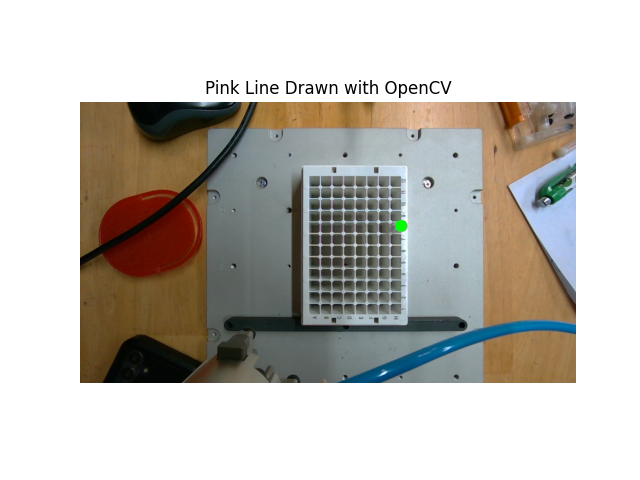

In [19]:
%matplotlib widget
import matplotlib.pyplot as plt
import cv2 as cv

# draw start end
img = detection.camera_data["color_img"].copy()

color = (255, 105, 180)  # Pink line

# Define thickness of the line
thickness = 1

# good
cv.circle(img, best_pick["center"], 10, (0, 255, 0), -1)


# Convert BGR to RGB for Matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.title("Pink Line Drawn with OpenCV")
plt.axis("off")  # Turn off axis
plt.show()

In [8]:
import json
for r in retval:
    print(json.dumps(r))

{"cmd": "jmove", "rel": 0, "j0": -17.23745545077685, "j1": 24.451511288443857, "j2": -115.9581308819732, "j3": -0.38274488970574794, "j4": 1.5912026382587898, "j5": -17.338841191643553, "vel": 18.0, "accel": 200.0, "jerk": 400.0, "cont": 0}
{"cmd": "jmove", "rel": 0, "j0": -17.238349753851367, "j1": 21.435851636968685, "j2": -114.35739816507538, "j3": -0.32946032835320693, "j4": 2.8851805777627164, "j5": -17.453536606890793}
{"cmd": "output", "out0": 1, "queue": 0}
{"cmd": "sleep", "time": 0.5}
{"cmd": "jmove", "rel": 0, "j0": -17.22198000401295, "j1": 43.23691680789746, "j2": -122.07936791487589, "j3": -0.5365152153063377, "j4": -11.16221037433877, "j5": -17.194922791872386, "vel": 10.0, "accel": 80.0, "jerk": 100.0, "cont": 1, "corner": 100}
{"cmd": "jmove", "rel": 0, "j0": -37.807199545110166, "j1": 45.99402035227921, "j2": -79.4676404974507, "j3": -2.3888607049276516, "j4": -56.75662415249667, "j5": -1.0356910753743023, "cont": 0}
{"cmd": "jmove", "rel": 0, "j0": -38.18599127816617

In [6]:
for r in result:
    if r["cls"] != "vial":
        print(r["center"])

    

[571, 378]
[395, 379]
[395, 109]
[570, 109]


In [7]:
import cv2
import numpy as np
from itertools import permutations

class Pose_estimator:
    def __init__(self, camera_matrix, dist_coeffs, min_error_threshold=5.0):
        """
        Initialize the Pose_estimator class.
        
        :param camera_matrix: Camera intrinsic matrix.
        :param dist_coeffs: Distortion coefficients of the camera.
        :param min_error_threshold: The minimum reprojection error threshold to accept a solution.
        """
        self.camera_matrix = camera_matrix
        self.dist_coeffs = dist_coeffs
        self.min_error_threshold = min_error_threshold

    def calculate_reprojection_error(self, object_points, image_points, rvec, tvec):
        """
        Calculate the reprojection error.

        :param object_points: 3D object points.
        :param image_points: 2D image points.
        :param rvec: Rotation vector.
        :param tvec: Translation vector.
        :return: Average reprojection error in pixels.
        """
        # Project 3D points to 2D
        projected_points, _ = cv2.projectPoints(object_points, rvec, tvec, self.camera_matrix, self.dist_coeffs)
        projected_points = projected_points.reshape(-1, 2)

        # Calculate the Euclidean distance between the projected points and the actual image points
        error = np.sqrt(np.sum((projected_points - image_points) ** 2, axis=1))
        # Return the average error in pixels
        return np.mean(error)

    def estimate_pose(self, object_points, image_points):
        """
        Estimate the pose (rvec and tvec) based on object points and image points.

        :param object_points: 3D object points.
        :param image_points: 2D image points.
        :return: (rvec, tvec) if a solution is found, None otherwise.
        """
        best_rvec = None
        best_tvec = None
        best_reprojection_error = float('inf')  # Initialize with a large value

        # Try all permutations of the image points
        for perm in permutations(image_points, len(image_points)):
            # Solve PnP using RANSAC to get the rotation (rvec) and translation (tvec)
            success, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, np.array(perm, dtype=np.float32), 
                                                               self.camera_matrix, self.dist_coeffs)
            
            if success:
                # Calculate reprojection error
                reprojection_error = self.calculate_reprojection_error(object_points, np.array(perm, dtype=np.float32), rvec, tvec)
                
                # If the reprojection error is smaller than the threshold, update the best solution
                if reprojection_error < best_reprojection_error and reprojection_error < self.min_error_threshold:
                    best_reprojection_error = reprojection_error
                    best_rvec = rvec
                    best_tvec = tvec

        if best_rvec is not None and best_tvec is not None:

            # Convert rotation vector to rotation matrix
            rotation_matrix, _ = cv2.Rodrigues(best_rvec)

            # Create a 4x4 transformation matrix
        else:
            return None, None

# Example usage

# Camera intrinsic parameters (replace with your actual camera matrix and distortion coefficients)
camera_matrix = camera.camera_matrix(detection.camera_data["depth_int"])
dist_coeffs = camera.dist_coeffs(detection.camera_data["depth_int"])

# 3D real-world coordinates of the corners of the object (in object space)
w = 85
h = 125
object_points = np.array([
    [0, 0, 0],   # Corner 1
    [w, 0, 0],   # Corner 2
    [w, h, 0],   # Corner 3
    [0, h, 0]    # Corner 4
], dtype=np.float32)

# Detected 2D image points of the corners (detected by your object detection)
image_points = np.array([
    [395, 109],  # Corner 1
    [571, 378],  # Corner 3
    [570, 109],  # Corner 2
    [395, 379]   # Corner 4
], dtype=np.float32)

image_points = [
    [395, 109],  # Corner 1
    [571, 378],  # Corner 3
    [570, 109],  # Corner 2
    [395, 379]   # Corner 4
]

# Initialize the Pose_estimator class
pose_estimator = Pose_estimator(camera_matrix, dist_coeffs, min_error_threshold=5)

# Estimate pose
T = pose_estimator.estimate_pose(object_points, image_points)

print(T)

None


In [48]:
x = [1, 2, 3,4]
print(x[0:2])

[1, 2]


In [9]:
x = np.array([[-0.99614615],
 [-0.00601865],
 [ 0.        ]])
z = np.array([[ 0],
 [ 0],
 [-1]])

print(x.flatten())
np.cross(z.flatten(), x.flatten()).reshape(-1, 1)

[-0.99614615 -0.00601865  0.        ]


array([[-0.00601865],
       [ 0.99614615],
       [ 0.        ]])

In [6]:
import numpy as np

# Define two vectors not along the same line
z = np.array([0, 0, -1])  # Z-axis
x = np.array([1, 0, 0])   # X-axis

# Compute the cross product
y = np.cross(z, x)

print("Cross product of z and x: ", y)


Cross product of z and x:  [ 0 -1  0]
